In [2]:
from numpy.random import normal
from math import sqrt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import Dataset
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import torchvision
import warnings
torch.set_default_tensor_type(torch.FloatTensor)
import copy
import random
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
# 设置随机数种子
setup_seed(20)

In [4]:
def make_txt_file(path):
    
    # Classes: train, eval, test
    img_path=os.path.join(path,'TrainVal_images')
    label_path=os.path.join(path,'TrainVal_parsing_annotations')
    train_data=open('train.txt', 'w')
    eval_data=open('eval.txt','w')
    test_data=open('test.txt','w')
    train_data.truncate()
    eval_data.truncate()
    test_data.truncate()
    train_id=open(os.path.join(path,'train_id.txt'))
    val_id=open(os.path.join(path,'val_id.txt'))
    
    train_data_path=os.path.join(img_path,'train_images')
    val_data_path=os.path.join(img_path,'val_images')
    train_label_path=os.path.join(label_path,'train_segmentations')
    val_label_path=os.path.join(label_path,'val_segmentations')
    
    lines=train_id.readlines()
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(train_data_path,line+'.jpg')+'*'+os.path.join(train_label_path,line+'.png')+'\n'
        train_data.write(name)
        count+=1
        if count>=10000:
            break
    train_data.close()
    train_id.close()
    
    lines=val_id.readlines()
    s=0
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(val_data_path,line+'.jpg')+'*'+os.path.join(val_label_path,line+'.png')+'\n'
        if s%2==0:
            eval_data.write(name)
        else:
            test_data.write(name)
        s+=1
        
        count+=1
        if count>=2000:
            break
            
    val_id.close() 
    eval_data.close()
    test_data.close()
                
    


In [5]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None,update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/pil-data/LIP'

        read_path=''
 
        if update_dataset:
            make_txt_file(dataset_path) 
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(os.path.join(read_path , self.dataset_type + '.txt'))
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('*')[0]).convert('RGB')       
        label = Image.open(item.split('*')[1]).convert('L')
        
        if self.transform is not None:
            img,label = self.transform(img,label)
           
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [6]:
def train_transform(data,label):
    dic={1:1,2:2,3:5,4:4,5:5,6:5,7:5,8:5,9:5,10:5,11:5,12:5,13:3,14:6,15:6,16:7,17:7,18:8,19:8}
    width=data.size[0]
    hight=data.size[1]
    if width>hight:
        pad=(width-hight)//2
        data=transforms.functional.pad(data,padding=(0,pad))
        label=transforms.functional.pad(label,padding=(0,pad))
    elif width<hight:
        pad=(hight-width)//2
        data=transforms.functional.pad(data,padding=(pad,0))
        label=transforms.functional.pad(label,padding=(pad,0))
                                        
        
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))   
   

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label,dtype='int64')
    changed_label=np.zeros_like(label)
    for i in range(1,20):
        changed_label+=(label==i)*dic[i]
    
    label=torch.from_numpy(changed_label)
    return data,label

def test_transfrom(data,label):
    dic={1:1,2:2,3:5,4:4,5:5,6:5,7:5,8:5,9:5,10:5,11:5,12:5,13:3,14:6,15:6,16:7,17:7,18:8,19:8}
    width=data.size[0]
    hight=data.size[1]
    if width>hight:
        pad=(width-hight)//2
        data=transforms.functional.pad(data,padding=(0,pad))
        label=transforms.functional.pad(label,padding=(0,pad))
    elif width<hight:
        pad=(hight-width)//2
        data=transforms.functional.pad(data,padding=(pad,0))
        label=transforms.functional.pad(label,padding=(pad,0))
                                        
        
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))   
   

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label,dtype='int64')
    changed_label=np.zeros_like(label)
    for i in range(1,20):
        changed_label+=(label==i)*dic[i]
    
    label=torch.from_numpy(changed_label)
    return data,label

In [7]:
train_data=MyDataSet('train',transform=train_transform,update_dataset=True)
eval_data=MyDataSet('eval',test_transfrom)
num_train=train_data.__len__()
num_eval=eval_data.__len__()

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,padding=1,bias=False),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3,padding=1,bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, input):        
        return self.conv(input)

In [9]:
class UNet(nn.Module):
    def __init__(self,colordim =1):
        super(UNet, self).__init__()
        self.conv1=DoubleConv(3,32)
        self.conv2=DoubleConv(32,64)
        self.conv3=DoubleConv(64,128)
        self.conv4=DoubleConv(128,256)
        
        self.conv5=DoubleConv(256,512)
        self.upconv5=nn.Conv2d(512, 256, 1)
        
        self.conv6=DoubleConv(512,256)
        self.upconv6=nn.Conv2d(256, 128, 1)
        self.conv7=DoubleConv(256,128)
        self.upconv7=nn.Conv2d(128,64, 1)
        self.conv8=DoubleConv(128,64)
        self.upconv8=nn.Conv2d(64,32, 1)
        self.conv9=DoubleConv(64,32)
        
        self.maxpool=nn.MaxPool2d(2, stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        self.output=nn.Sequential(
            nn.Conv2d(32, colordim, 1),
        )
        self._initialize_weights()
    
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(self.maxpool(x1))
        x3=self.conv3(self.maxpool(x2))
        x4=self.conv4(self.maxpool(x3))
        upx=self.conv5(self.maxpool(x4))
        
        upx=self.upconv5(self.upsample(upx))     

        upx=self.conv6(torch.cat((x4, upx), 1))
        upx=self.upconv6(self.upsample(upx))   

        upx=self.conv7(torch.cat((x3, upx), 1))
        upx=self.upconv7(self.upsample(upx))  

        upx=self.conv8(torch.cat((x2, upx), 1))
        upx=self.upconv8(self.upsample(upx)) 

        upx=self.conv9(torch.cat((x1, upx), 1))
        upx=self.output(upx)
        
        return upx
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()        
        
        



In [10]:
unet = UNet(colordim=9).cuda()
# unet.load_state_dict(torch.load('../input/body-weight/s_30000_20.pkl'))

In [11]:
EPOCH = 60
BATCH_SIZE=32
LR=0.001

optimizer=torch.optim.Adam(unet.parameters(),lr=LR)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
    verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)

loss_func=nn.CrossEntropyLoss()



train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=8)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=8)

In [12]:
def mIoUAcc(inputs, targets,numclass=9, smooth=1):
    inputs=torch.softmax(inputs,dim=1)
    inputs = inputs.cpu().detach()
    targets = targets.cpu().detach().view(-1)      
    
    IoU=[]
    for i in range(numclass):        
        pre=torch.tensor(inputs[:,i,:,:]).view(-1)
        target=targets==i
        intersection = (pre * target).sum().numpy()
        total = (pre + target).sum().numpy()
        union = total - intersection         
        IoU.append((intersection + smooth)/(union + smooth))
    return np.mean(IoU)

In [13]:
num_train

10000

In [14]:
train_losses=[]
eval_losses=[]
train_accs=[]
eval_accs=[]


for epoch in range(EPOCH):
    print('Epoch: %4s'%epoch)
    

    batch_loss=0
    acc=0
    unet.train()  
    
    for step,(b_x,b_y) in enumerate(train_loader):
        b_x=b_x.cuda()
        b_y=b_y.cuda()
        
        output=unet(b_x)   
        loss=loss_func(output,b_y)
        batch_loss+=loss.item()*b_y.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        torch.cuda.empty_cache() 
        acc+=mIoUAcc(output,b_y)*b_y.size(0)

    train_loss=batch_loss/num_train
    train_acc=acc/num_train
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    scheduler.step(train_loss) 
    
    print('| train loss: ',train_loss,'| train accuracy: ',train_acc)
    
    
    
    with torch.no_grad():
        unet.eval()         
        acc=0
        batch_loss=0
        for step,(b_x,b_y) in enumerate(eval_loader):
            b_x=b_x.cuda()
            b_y=b_y.cuda()    
            output=unet(b_x) 
            batch_loss+=loss_func(output,b_y).item()*b_y.size(0)            
            torch.cuda.empty_cache()   
            acc+=mIoUAcc(output,b_y)*b_y.size(0)

        eval_loss=batch_loss/num_eval
        eval_acc=acc/num_eval
        eval_losses.append(eval_loss)
        eval_accs.append(eval_acc)

    
    print('| eval loss: ',eval_loss,'| eval accuracy: ',eval_acc) 

Epoch:    0
| train loss:  0.8401435809135437 | train accuracy:  0.1256422219812067
| eval loss:  0.597969563484192 | eval accuracy:  0.14744704595878572
Epoch:    1
| train loss:  0.6422838572502136 | train accuracy:  0.1634995014696805
| eval loss:  0.5395388078689575 | eval accuracy:  0.1717342734202007
Epoch:    2
| train loss:  0.5906374959945678 | train accuracy:  0.1879961629692476
| eval loss:  0.45969195175170896 | eval accuracy:  0.20459464382080134
Epoch:    3
| train loss:  0.5427828038215637 | train accuracy:  0.2160690294607521
| eval loss:  0.4366046080589294 | eval accuracy:  0.21991888521716396
Epoch:    4
| train loss:  0.5100802233695984 | train accuracy:  0.2369894398749777
| eval loss:  0.7738346295356751 | eval accuracy:  0.18669500285887847
Epoch:    5
| train loss:  0.4786371479511261 | train accuracy:  0.2587634910331155
| eval loss:  0.38342900586128237 | eval accuracy:  0.26662468196153744
Epoch:    6
| train loss:  0.4546379395008087 | train accuracy:  0.275

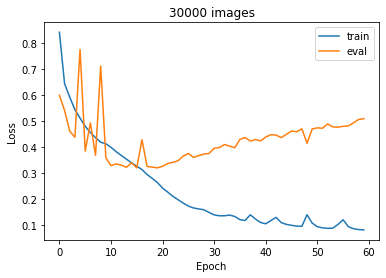

In [15]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('30000 images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

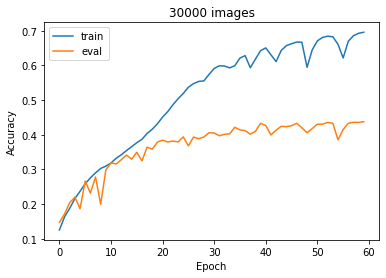

In [16]:
plt.plot(x,train_accs,label='train')
plt.plot(x,eval_accs,label='eval')
plt.title('30000 images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
num_figure=8
imgs=np.arange(num_figure)*10

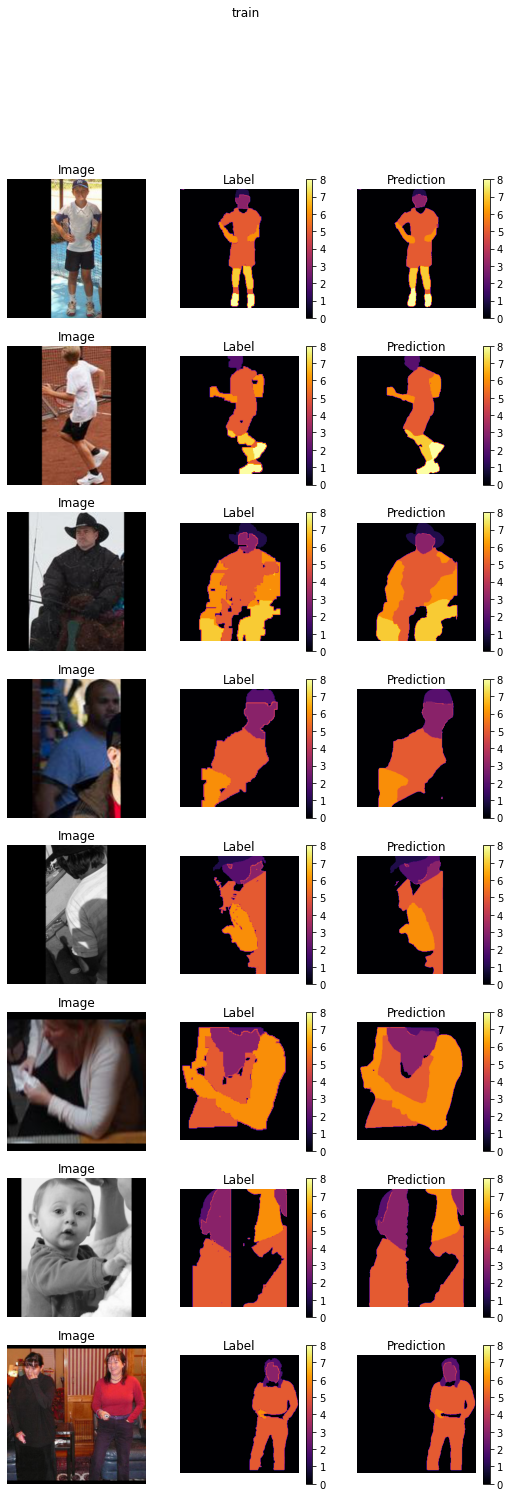

In [18]:
plt.figure(figsize=(9,24))



count=1
for i in imgs:
    
    img,label=train_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.title('Image')
    
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    label=label.numpy()
    label[0,:9]=np.arange(9)
    plt.imshow(label,plt.get_cmap('inferno'))
    plt.axis('off')
    plt.title('Label')
    plt.colorbar(ticks=np.arange(9))
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    img=torch.unsqueeze(img,dim=0)
    b_x=Variable(img).cuda()
    output=unet(b_x).to(torch.float64)
    output=torch.max(output,1)[1].cpu().detach().numpy()[0]
    output[0,:9]=np.arange(9)
    plt.imshow(output,plt.get_cmap('inferno'))
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(ticks=np.arange(9))
    count+=1
    
plt.suptitle('train') 

plt.show()

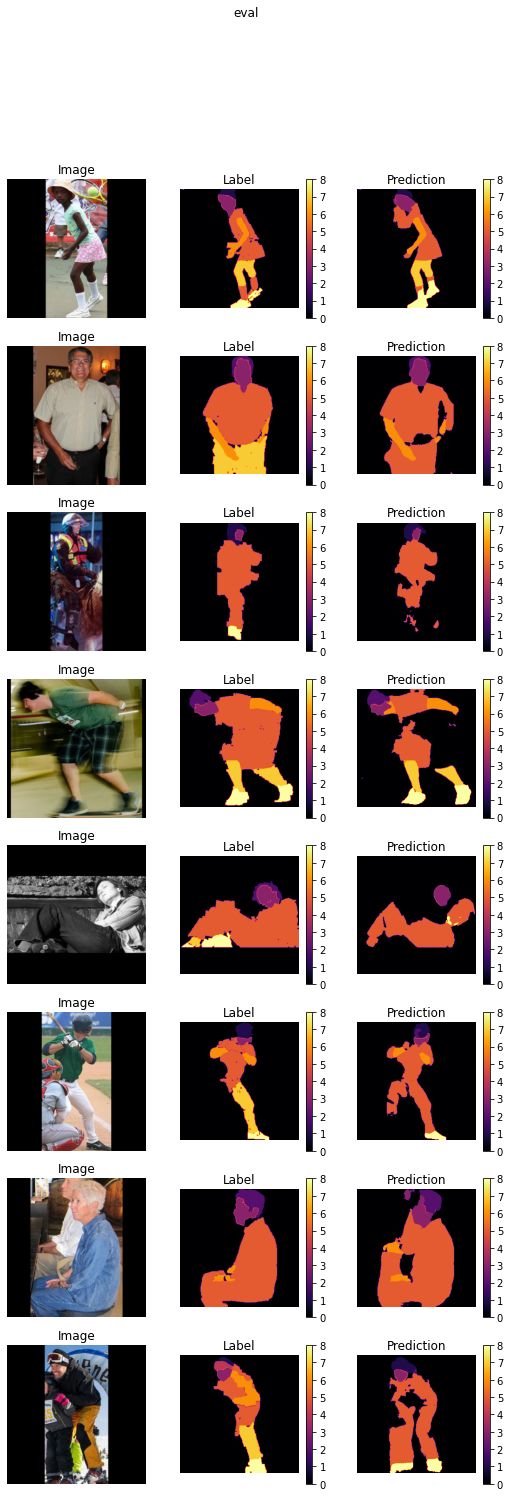

In [19]:
plt.figure(figsize=(9,24))

import matplotlib as mpl 
 

count=1
for i in imgs:
    
    img,label=eval_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.title('Image')
    
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    label=label.numpy()
    label[0,:9]=np.arange(9)
    plt.imshow(label,plt.get_cmap('inferno'))
    plt.axis('off')
    plt.title('Label')
    plt.colorbar(ticks=np.arange(9))
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    img=torch.unsqueeze(img,dim=0)
    b_x=Variable(img).cuda()
    output=unet(b_x).to(torch.float64)
    output=torch.max(output,1)[1].cpu().detach().numpy()[0]
    output[0,:9]=np.arange(9)
    plt.imshow(output,plt.get_cmap('inferno'))
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(ticks=np.arange(9))
    count+=1
    
plt.suptitle('eval') 

plt.show()

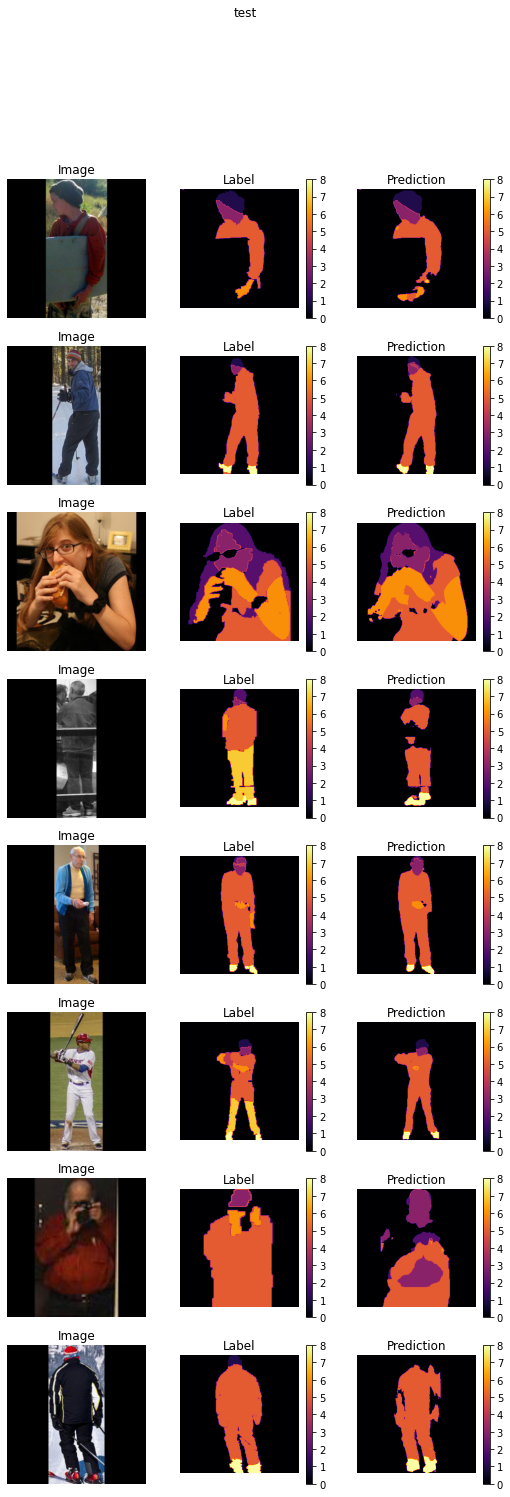

In [20]:
test_data=MyDataSet('test',test_transfrom)
plt.figure(figsize=(9,24))

import matplotlib as mpl 
 

count=1
for i in imgs:
    
    img,label=test_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.title('Image')
    
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    label=label.numpy()
    label[0,:9]=np.arange(9)
    plt.imshow(label,plt.get_cmap('inferno'))
    plt.axis('off')
    plt.title('Label')
    plt.colorbar(ticks=np.arange(9))
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    img=torch.unsqueeze(img,dim=0)
    b_x=Variable(img).cuda()
    output=unet(b_x).to(torch.float64)
    output=torch.max(output,1)[1].cpu().detach().numpy()[0]
    output[0,:9]=np.arange(9)
    plt.imshow(output,plt.get_cmap('inferno'))
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(ticks=np.arange(9))
    count+=1
    
plt.suptitle('test') 

plt.show()

In [21]:
torch.save(unet.state_dict(),'10000_60.pkl')